Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 60.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.98MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.21MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/20], Loss: 0.08036436619325277
Epoch [2/20], Loss: 0.022468043609984945
Epoch [3/20], Loss: 0.011461903191394816
Epoch [4/20], Loss: 0.009247425870609694
Epoch [5/20], Loss: 0.009069826313069703
Epoch [6/20], Loss: 0.005502830888517143
Epoch [7/20], Loss: 0.005393393317822607
Epoch [8/20], Loss: 0.0010959952502354409
Epoch [9/20], Loss: 0.0012713841858098128
Epoch [10/20], Loss: 0.0031916681393548765
Epoch [11/20], Loss: 0.008477864356004231
Epoch [12/20], Loss: 0.007734889555586325
Epoch [13/20], Loss: 0.006344927300522006
Epoch [14/20], Loss: 0.00717994906069763
Epoch [15/20], Loss: 0.005863412203553543
Epoch [16/20], Loss: 0.0025627887743138542
Epoch [17/20], Loss: 0.004368264214396271
Epoch [18/20], Loss: 7.514519602150527e-05
Epoch [19/20], Loss: 2.800455566444988e-05
Epoch [20/20], Loss: 2.03830832740859e-05
Accuracy on adversarial examples: 8.736689254598257%


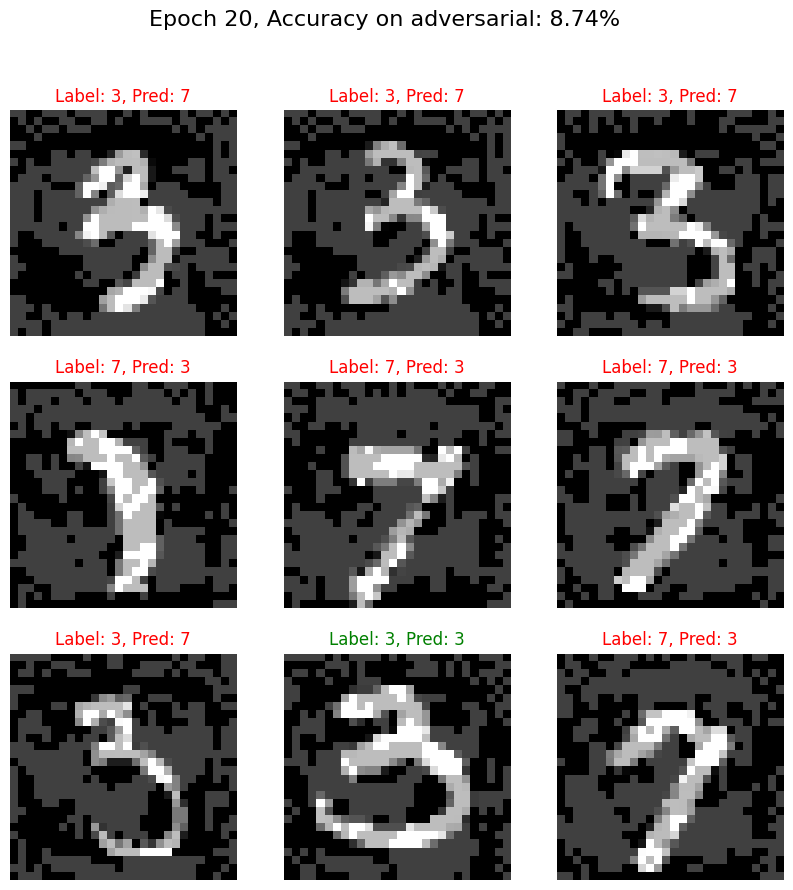

In [1]:
# @title Bonne version, rnn simple avec epsilon = 0.25
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    # Assurez-vous que les gradients sont activés pour les images
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()



    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Clipper les valeurs des pixels dans [0, 1]

    return adversarial_images

# Classe du modèle (réseau neuronal simple)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplatir l'image en vecteur
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données MNIST (avec uniquement des 3 et des 7)
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Filtrer les données pour ne garder que les 3 et les 7
    indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == 3 or full_dataset.targets[i] == 7]
    filtered_dataset = Subset(full_dataset, indices)

    train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  # Assurez-vous que le modèle est en mode évaluation

    correct = 0
    total = 0

    for images, labels in train_loader:
        # Ensure images require gradients before FGSM
        images = images.clone().detach().requires_grad_(True)

        # La génération d'exemples adversariaux nécessite des gradients
        # images.requires_grad = True  # Activation des gradients # No longer needed here
        adversarial_images = FGSM(model, images, labels, epsilon)

        # Tester sur des exemples adversariaux
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    # Charger les données (avec uniquement des 3 et des 7)
    train_loader = load_data()

    # Initialiser le modèle et l'optimiseur
    model = SimpleNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()

Premier réseau de neurone simple, le but est de mettre en lumière l'incapacité du réseau à bien reconnaitre les 3 et les 7 extraits du dataset MNIST alors que c'est très simple à l'oeil nu.